In [1]:
import os  # Import the os module for operating system related functionalities

import torch  # Import the torch module for deep learning functionalities
import torchvision  # Import the torchvision module for computer vision tasks
import torchvision.transforms as transforms  # Import the transforms module for data transformations

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    

def restrict_GPU_pytorch(gpuid, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        print("Using GPU:{}".format(gpuid))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

restrict_GPU_pytorch('2,6,7')

Using GPU:2,6,7


In [2]:
# Get models
model_names = ['ResNet50', 'ResNet101', 'ResNet152']

models = [torchvision.models.resnet50(pretrained=True, progress=True),
          torchvision.models.resnet101(pretrained=True, progress=True),
          torchvision.models.resnet152(pretrained=True, progress=True)]

dataset_name = 'ImageNet'



# Get dataloader for ImageNet
transforms_list = [transforms.Resize(size=256),
                    transforms.CenterCrop(size=224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                   ]
transform = transforms.Compose(transforms_list)
dataset = ImageFolderWithPaths("/data/ddmg/prism/conformal_prediction/data/imagenet/val/", transform = transform)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)

/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also 

In [3]:
import numpy as np
from tqdm.notebook import tqdm
# Generate predictions for each model
# Eventually we will want to write out files containing model predictions
# for each model x dataset we consider.

import os
import numpy as np

model_pred_labels_path = '/data/ddmg/frank/shuvom/pred_matrices/model_pred_labels.npy'
true_labels_path = '/data/ddmg/frank/shuvom/pred_matrices/true_labels.npy'

if not os.path.exists(model_pred_labels_path) or not os.path.exists(true_labels_path):
    n_models = len(models)
    n_examples = len(dataloader.dataset)
    model_pred_labels = np.zeros((n_examples, n_models))
    for j, model in enumerate(models):
        print("Model: {}".format(model_names[j]))
        
        model.cuda()
        model.eval()
        
        outputs = []
        labels = []
        for i, batch in tqdm(enumerate(dataloader)):
            inputs = batch[0].cuda()
            batch_label = batch[1]     

            batch_output = model(inputs.float()).detach().cpu().numpy()

            outputs.append(batch_output)
            labels.append(batch_label)
            
        # Removing model from GPU to make space for the next one
        model.to(torch.device('cpu'))
        outputs = np.concatenate(outputs, axis=0)
        true_labels = np.concatenate(labels)
        
        # Only saving out the top prediction to save space 
        pred_labels = np.argmax(outputs, axis=1)
        model_pred_labels[:,j] = pred_labels
        
        torch.cuda.empty_cache()
        
    np.save(true_labels_path, true_labels)
else:
    model_pred_labels = np.load(model_pred_labels_path)
    true_labels = np.load(true_labels_path)


Model: ResNet50


0it [00:00, ?it/s]

Model: ResNet101


0it [00:00, ?it/s]

Model: ResNet152


0it [00:00, ?it/s]

In [4]:
diff_predictions = np.sum(np.diff(model_pred_labels, axis=1) != 0, axis=1)
num_diff_predictions = np.sum(diff_predictions > 0)
print(f'Number of rows where not all three models have the same prediction: {num_diff_predictions}')

from itertools import combinations

# Generate all pairs of models
model_pairs = list(combinations(range(n_models), 2))

# For each pair of models, print the number of disagreements
for pair in model_pairs:
    disagreements = np.sum(model_pred_labels[:, pair[0]] != model_pred_labels[:, pair[1]])
    print(f'Number of disagreements between model {pair[0]} and model {pair[1]}: {disagreements}')

np.save('/data/ddmg/frank/shuvom/pred_matrices/model_pred_labels.npy', model_pred_labels)


Number of rows where not all three models have the same prediction: 11105
Number of disagreements between model 0 and model 1: 8472
Number of disagreements between model 0 and model 2: 8385
Number of disagreements between model 1 and model 2: 7819


In [6]:
true_labels.shape
model_pred_labels.shape

(50000, 3)

In [7]:
true_labels = np.array(true_labels).astype(int)


# subsample the dataset for speed
sample_idxs = np.random.choice(list(range(50000)), replace=False, size=2000)
sampled_outputs = outputs[sample_idxs]
sampled_labels = true_labels[sample_idxs]
sampled_pred_labels = model_pred_labels[sample_idxs]

Model: ResNet-50
Model accuracy: [3.200000e-04 6.400000e-04 9.600000e-04 ... 1.599744e+01 1.599872e+01
 1.599968e+01]


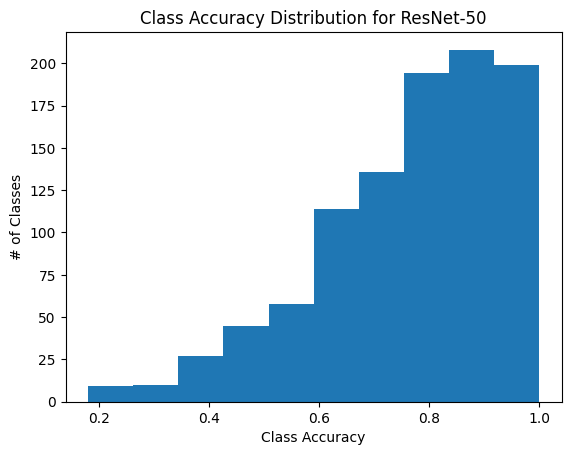

In [8]:
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# import matplotlib.pyplot as plt
# Model accuracy
model_idx = 0
model_name = 'ResNet-50'
acc = np.where(model_pred_labels[:,model_idx] == true_labels)[0]/len(labels)

# Class-specific accuracy for each model
n_classes = 1000
class_accs = [] 
for i in range(n_classes):
    class_accs.append(np.mean(model_pred_labels[:,model_idx][true_labels == i] == i))
plt.hist(class_accs)
plt.xlabel("Class Accuracy")
plt.ylabel("# of Classes")
plt.title(f"Class Accuracy Distribution for {model_name}")
# i.e. for each class, which model is the best.

print(f'Model: {model_name}')
print(f'Model accuracy: {acc}')


In [9]:
# Generate a n examples x n models x n classes matrix 
# where one_hot_model_predictions[i][j][k] = 1 if model j predicts example i to be class k 
n_examples = len(sampled_pred_labels)


model_predictions = []  # Initialize an empty list to store model predictions
for i in range(3):  # Loop over the three models
    pred_labels = sampled_pred_labels[:,i]  # Get the predicted labels for the current model
    one_hot_pred_labels = np.zeros((n_examples, 1000))  # Initialize a one-hot encoded array for the predicted labels
    one_hot_pred_labels[list(range(n_examples)), pred_labels.astype(int)] = 1  # One-hot encode the predicted labels
    model_predictions.append(one_hot_pred_labels)  # Append the one-hot encoded predictions to the list
one_hot_predictions_all_classes = np.stack(model_predictions, axis = 1)  # Stack the one-hot encoded predictions for all models


In [10]:
import numpy as np

# The following code is the original code, commented out as per the instructions
# class_idx = 1 
# one_hot_preds_one_class = []
# n_classes = 2
# n_examples = len(model_pred_labels)
# for i in range(3):
#     one_hot_one_class = np.zeros((n_examples, n_classes))
#     one_class_preds = (model_pred_labels[:,i] == class_idx).astype(int)
#     one_hot_one_class[list(range(n_examples)),one_class_preds] = 1
#     one_hot_preds_one_class.append(one_hot_one_class)
# one_hot_predictions_one_class = np.stack(one_hot_preds_one_class, axis = 1)
# one_hot_predictions_one_class.shape

# class_idx = 1 
# binarized_model_predictions = []
# for i in range(3):
#     binary_model_predictions = (model_pred_labels[:,i] == class_idx).astype(int)
#     binarized_model_predictions.append(binary_model_predictions)
# binarized_model_predictions = np.stack(binarized_model_predictions, axis=1)
# binarized_model_predictions.shape

# from dawid_skene import run
# This is really slow because there are so many classes. 
# We could also make this easier by turning ImageNet into a binary problem for a particular class.
# _, _, _, _, _, error_rates, _ = run(one_hot_predictions_one_class)
selected_classes = np.random.choice(range(1000), size=100, replace=False)

error_rates_all_classes = []  # Initialize a list to store error rates for all classes
# num_classes = 100

for idx, class_idx in enumerate(selected_classes):  # Loop over selected classes
    print(f'\rProcessing class: {class_idx}, number: {idx}', end='')  # Print the current class index with rolling output
    one_hot_preds_one_class = []
    n_classes = 2
    n_examples = len(model_pred_labels)
    for i in range(3):
        one_hot_one_class = np.zeros((n_examples, n_classes))
        one_class_preds = (model_pred_labels[:,i] == class_idx).astype(int)
        one_hot_one_class[list(range(n_examples)),one_class_preds] = 1
        one_hot_preds_one_class.append(one_hot_one_class)
    one_hot_predictions_one_class = np.stack(one_hot_preds_one_class, axis = 1)

    binarized_model_predictions = []
    for i in range(3):
        binary_model_predictions = (model_pred_labels[:,i] == class_idx).astype(int)
        binarized_model_predictions.append(binary_model_predictions)
    binarized_model_predictions = np.stack(binarized_model_predictions, axis=1)

    from dawid_skene import run
    import sys
    import os
    # Create a dummy file to redirect output
    with open(os.devnull, 'w') as f:
        # Save the current stdout
        old_stdout = sys.stdout
        # Set stdout to the dummy file
        sys.stdout = f
        # Run the function with print statements muted
        _, _, _, _, _, error_rates, _ = run(one_hot_predictions_one_class)
        # Restore stdout
        sys.stdout = old_stdout
    error_rates_all_classes.append(error_rates)  # Append the error rates for the current class to the list




Processing class: 426, number: 99

In [11]:
error_rates_all_classes = np.array(error_rates_all_classes)  # Convert the list to a numpy array
np.save('/data/ddmg/frank/shuvom/pred_matrices/ds_error_rates_all_classes.npy', error_rates_all_classes)  # Save the error rates
np.save('/data/ddmg/frank/shuvom/pred_matrices/selected_classes.npy', selected_classes)  # Save the selected classes


### Dawid-Skene

In [12]:
# n_classes
# model_per_class_accuracy = []
# for model_idx in range(n_models):
#     model_accuracy = []
#     for class_idx in selected_classes:
#         true_labels_class = (true_labels == class_idx).astype(int)
#         model_pred_labels_class = (model_pred_labels[:, model_idx] = class_idx).astype(int)
#         accuracy = np.mean(true_labels_class == model_pred_labels_class)
#         model_accuracy.append(accuracy)
#     model_per_class_accuracy.append(model_accuracy)

# model_per_class_accuracy = np.array(model_per_class_accuracy)
# print('Model per class accuracy:', model_per_class_accuracy)

# model_pred_labels.shape
# for class_idx in selected_classes:
#     # Error rates for each of the models, for this class. 
#     model_accuracy = error_rates_all_classes[class_idx, :, 1, 1]  # Extract the accuracy of each model for the class
#     model_rankings = model_accuracy.argsort() + 1  # Rank the models for the class

#     # Create a dictionary to store the frequency of each ranking
#     ranking_dict = {tuple(i): 0 for i in itertools.permutations(range(1, len(model_names) + 1))}

#     # Count the frequency of each ranking
#     for ranking in model_rankings:
#         ranking_dict[tuple(ranking)] += 1

#     # Calculate the relative frequency of each ranking
#     relative_frequency = {k: v / np.sum(list(ranking_dict.values())) for k, v in ranking_dict.items()}

#     # Plot a histogram of the relative frequency of all rankings
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(relative_frequency)), list(relative_frequency.values()), align='center')
#     plt.xticks(range(len(relative_frequency)), list(relative_frequency.keys()))
#     plt.xlabel('Ranking')
#     plt.ylabel('Relative Frequency')
#     plt.title(f'Histogram of Relative Frequency of All Rankings for Class {class_idx}')
#     plt.show()


In [13]:
# error_rates_all_classes.shape

error_rates_all_classes

(100, 3, 2, 2)

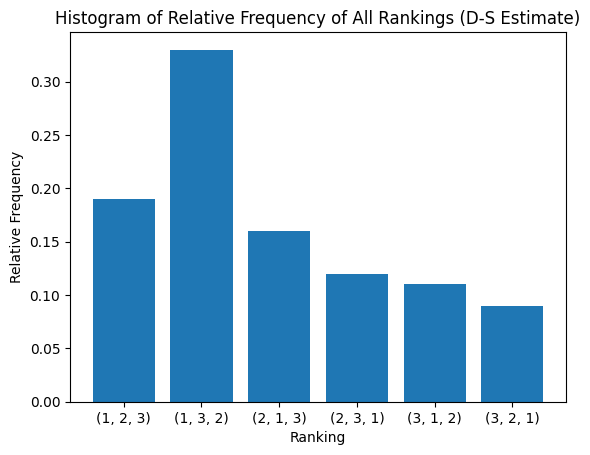

In [63]:
# Error rates for each of the models, for this class. 
model_accuracy = error_rates_all_classes[:, :, 1, 1]  # Extract the accuracy of each model for each class
model_rankings = model_accuracy.argsort(axis=1) + 1  # Rank the models for each class

# print(model_accuracy)
# Store the rankings
np.save('/data/ddmg/frank/shuvom/pred_matrices/model_rankings.npy', model_rankings)


import matplotlib.pyplot as plt
import itertools


# Create a dictionary to store the frequency of each ranking
ranking_dict_ds = {tuple(i): 0 for i in itertools.permutations(range(1, len(model_names) + 1))}

# Count the frequency of each ranking
for ranking in model_rankings:
    ranking_dict_ds[tuple(ranking)] += 1

# Calculate the relative frequency of each ranking
relative_frequency = {k: v / np.sum(list(ranking_dict_ds.values())) for k, v in ranking_dict_ds.items()}

# Plot a histogram of the relative frequency of all rankings
plt.bar(range(len(relative_frequency)), list(relative_frequency.values()), align='center')
plt.xticks(range(len(relative_frequency)), list(relative_frequency.keys()))
plt.xlabel('Ranking')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Relative Frequency of All Rankings (D-S Estimate)')
plt.show()


# model_rankings.flatten()


In [72]:
# np.sum(np.abs(model_rankings - model_rankings_ds), axis=1)
# np.abs(model_rankings - model_rankings_true).sum(axis=1) == 0

selected_classes[3]

221

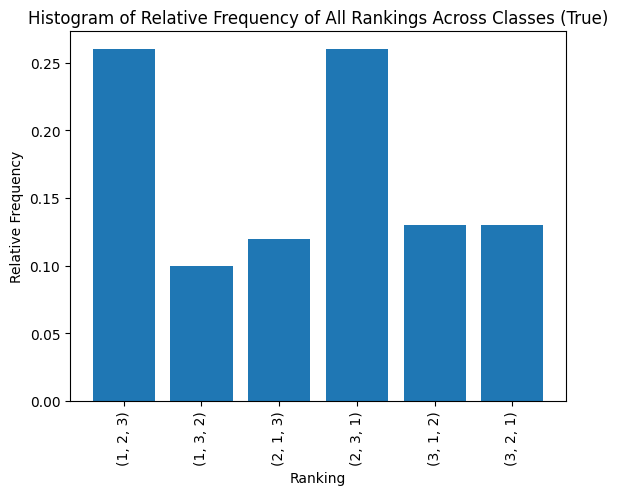

In [66]:
import collections

# Create a list to store the rankings of all classes
ranking_dict_true = {tuple(i): 0 for i in itertools.permutations(range(1, len(model_names) + 1))}
model_trues = []

for class_idx in selected_classes:
    # Extract the predictions of each model for this class
    model_predictions = model_pred_labels[true_labels == class_idx]
    
    
    # Calculate the error rates for this class
    model_error_rates = np.mean(model_predictions != class_idx, axis=0)
    # print(model_error_rates)
    
    # Rank the models for this class
    model_rankings_true = model_error_rates.argsort() + 1
    model_trues.append(model_rankings_true)
    
    # Add the rankings to the list
    # all_class_rankings.append(tuple(model_rankings))
    ranking_dict_true[tuple(model_rankings_true)] += 1


# Count the frequency of each ranking
relative_frequency = {k: v / np.sum(list(ranking_dict_true.values())) for k, v in ranking_dict_true.items()}


# Plot a histogram of the relative frequency of all rankings
plt.bar(range(len(relative_frequency)), list(relative_frequency.values()), align='center')
plt.xticks(range(len(relative_frequency)), [str(k) for k in relative_frequency.keys()], rotation=90)
plt.xlabel('Ranking')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Relative Frequency of All Rankings Across Classes (True)')
plt.show()



In [38]:
# matching_indices_count = np.sum(model_rankings_ds == model_rankings_true)
# print("Number of matching indices: ", matching_indices_count)



Number of matching indices: 2


In [37]:
# model_rankings_ds


array([[3, 1, 2],
       [2, 3, 1],
       [1, 3, 2],
       [1, 2, 3],
       [2, 3, 1],
       [2, 1, 3],
       [1, 3, 2],
       [3, 1, 2],
       [1, 3, 2],
       [1, 2, 3],
       [1, 3, 2],
       [1, 3, 2],
       [2, 1, 3],
       [1, 3, 2],
       [1, 2, 3],
       [1, 2, 3],
       [1, 3, 2],
       [1, 2, 3],
       [3, 2, 1],
       [1, 2, 3],
       [3, 1, 2],
       [3, 1, 2],
       [3, 1, 2],
       [1, 3, 2],
       [1, 3, 2],
       [1, 3, 2],
       [1, 3, 2],
       [2, 1, 3],
       [3, 2, 1],
       [2, 1, 3],
       [3, 2, 1],
       [1, 2, 3],
       [1, 3, 2],
       [1, 2, 3],
       [1, 3, 2],
       [1, 2, 3],
       [3, 2, 1],
       [2, 1, 3],
       [1, 3, 2],
       [1, 3, 2],
       [1, 2, 3],
       [3, 2, 1],
       [3, 1, 2],
       [1, 3, 2],
       [2, 3, 1],
       [1, 3, 2],
       [1, 2, 3],
       [3, 1, 2],
       [2, 1, 3],
       [2, 1, 3],
       [1, 2, 3],
       [2, 3, 1],
       [2, 3, 1],
       [3, 1, 2],
       [2, 3, 1],
       [3,

In [ ]:
from dawid_skene import run
# This is really slow because there are so many classes.
run(one_hot_model_predictions)

num Patients: 2000
Observers: [0, 1, 2]
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 

### Walter & Lui